In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats

_SAMPLES_DIR = './samples/'

In [2]:
USER_SAMPLES_DIR = 'User_0_13_Tethered/'
_DATA_DIR = os.path.join(_SAMPLES_DIR, _USER_SAMPLES_DIR)

In [4]:
trials_raw_df = pd.read_csv(os.path.join(_DATA_DIR, 'trials.csv'))
trials_df = trials_raw_df[trials_raw_df['trial_index']>=0]
trials_df

unix_ms  trial_index      trial_name
1  1754442487342            0  Restricted_40d
2  1754442531203            1  Restricted_30d
3  1754442582024            2        Free_40d
4  1754442634050            3        Free_10d
5  1754442684594            4        Free_20d
6  1754442732219            5  Restricted_10d
7  1754442779923            6        Free_30d
8  1754442827537            7  Restricted_20d

# Trial Processing Functions

## Load Trial Data

In [5]:
def load_trial(trial_name:str):
    # load raw trial data
    df = pd.read_csv(os.path.join(_DATA_DIR, f'{trial_name}.csv'))
    return df
    
def load_steps(df):
    # load steps within the trial
    start_indices = df.index[df['event']=='Target Loaded'].tolist()
    end_indices = start_indices[1:] + [len(df)]
    steps = [df.iloc[start:end] for start,end in zip(start_indices,end_indices)]
    return steps

## Steps --> Halves

In [6]:
def process_steps(steps):
    # Pre-define output array + columns we are interested in
    halves = []
    filter_cols = [
        'unix_ms',
        'event',
        'avg_target_diff',
        'head_target_diff',
        'avg_head_diff'
    ]
    
    # Iterate through each step, which should amount to 9 for a trial
    for step_df in steps:
        # Get the row indices for the loaded, transitioning, and set events
        phase0_idx = step_df.index[step_df['event'] == 'Target Loaded'].tolist()
        phase1_idx = step_df.index[step_df['event'] == 'Targit Transitioning'].tolist()
        phase2_idx = step_df.index[step_df['event'] == 'Target Set'].tolist()
        
        # If the indices are not null, store what the indices are
        phase0_start = phase0_idx[0] if phase0_idx else None
        phase1_start = phase1_idx[0] if phase1_idx else None
        phase2_start = phase2_idx[0] if phase2_idx else None

        # Define the output dfs we'll be storing in `halves`
        phase0_df = pd.DataFrame(columns=filter_cols)
        phase1_df = pd.DataFrame(columns=filter_cols)
        phase2_df = pd.DataFrame(columns=filter_cols)

        if (phase1_start is not None and phase2_start is not None):
            # Both halves are present
            phase0_df = step_df.loc[[phase0_start,phase1_start,phase2_start]][filter_cols]
            phase0_df['step_ms'] = phase0_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
            phase1_df = step_df.loc[phase1_start:phase2_start-1][filter_cols]
            phase1_df['step_ms'] = phase1_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
            phase2_df = step_df.loc[phase2_start:][filter_cols]
            phase2_df['step_ms'] = phase2_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
        elif phase2_start is not None:
            # Only second half present
            phase0_df = step_df.loc[[phase0_start,phase2_start]][filter_cols]
            phase0_df['step_ms'] = phase0_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
            phase2_df = step_df.loc[phase2_start:][filter_cols]
            phase2_df['step_ms'] = phase2_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
        elif phase1_start is not None:
            # Only first half is present
            phase0_df = step_df.loc[[phase0_start, phase1_start]][filter_cols]
            phase0_df['step_ms'] = phase0_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
            phase1_df = step_df.loc[phase1_start:][filter_cols]
            phase1_df['step_ms'] = phase1_df['unix_ms'] - phase0_df.loc[phase0_start]['unix_ms']
        
        # store the halves + timestamps for events
        halves.append((phase1_df, phase2_df, phase0_df))
    
    # return halves
    return halves

## Angular Diff in Gaze Target Position Between Trials

In [7]:
def calculate_target_diffs(steps):
    # Initialize
    angular_diffs = []
    prev_vector = None

    # Iterate through each step_df
    for step_df in steps:
        # Find the "Target Loaded" row
        start_row = step_df[step_df['event'] == 'Target Loaded']
        # Edge case: if no start row, just enter NaN
        if start_row.empty:
            angular_diffs.append(np.nan)
            continue
        # Extract x,y,z from this row
        vector = start_row[['calib_dir_x','calib_dir_y','calib_dir_z']].values[0]
        if prev_vector is None:
            angular_diffs.append(0.0)
        else:
            # Compute angle in radians
            dp = np.dot(prev_vector, vector)
            norm_product = np.linalg.norm(prev_vector) * np.linalg.norm(vector)
            # prevent numerical issues
            cos_theta = np.clip(dp / norm_product, -1.0, 1.0)
            angle_rad = np.arccos(cos_theta)
            # Convert into degrees
            angle_deg = np.degrees(angle_rad)
            # Add to angular_diffs
            angular_diffs.append(angle_deg)
        # Update previous vector
        prev_vector = vector
    return angular_diffs

## Plotting

In [23]:
def plot_halves(halves, angular_diffs, figsize=(15,20), legend_fontsize=8):
    # SUBPLOTS:
    # cols = diff with gaze target, diff with head
    # rows = trials

    # for each subplot
    # x-axis = time
    # y-axis = diff

    fig,axes =  plt.subplots(nrows=len(halves), ncols=2, figsize=figsize, sharex=True, sharey=True)
    for step_index in range(0,len(halves)):
        steps = halves[step_index]
        if len(steps[0].index) > 0:
            # The transitions halves exist
            # - Avg-related
            steps[0].plot(x='step_ms',y='avg_target_diff', ax=axes[step_index][0], c='blue', label='Eye: Transition')
            steps[0].plot(x='step_ms',y='avg_head_diff', ax=axes[step_index][1], c='blue', label='Transition')
            # - Head-related
            steps[0].plot(x='step_ms',y='head_target_diff', ax=axes[step_index][0], c='orange', label='Head: Transitioning')
            # Vertical Line when target is set
        if len(steps[1].index) > 0:
            # The target set halves exist
            # - Avg-related
            steps[1].plot(x='step_ms',y='avg_target_diff', ax=axes[step_index][0], c='purple', label='Eye: Set Target')
            steps[1].plot(x='step_ms',y='avg_head_diff', ax=axes[step_index][1], c='purple', label='Set Target')
            # - Head-related
            steps[1].plot(x='step_ms',y='head_target_diff', ax=axes[step_index][0], c='red', label='Head: Set Target')
        
        axes[step_index][0].axvline(x=steps[2][steps[2]['event']=='Target Set']['step_ms'].values[0])
        axes[step_index][0].set_title(f'Eye, Head VS Target | Target Diff: {angular_diffs[step_index]}')
        axes[step_index][0].legend(prop=dict(size=legend_fontsize))
        axes[step_index][1].axvline(x=steps[2][steps[2]['event']=='Target Set']['step_ms'].values[0])
        axes[step_index][1].set_title(f'Eye VS Head | Target Diff: {angular_diffs[step_index]}')
        axes[step_index][1].legend(prop=dict(size=legend_fontsize))
        for ax in axes.flatten():
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.yaxis.set_tick_params(labelleft=True)

## Accuracy and Precision

In [75]:
def calculate_performance(halves, angular_diffs):
    # halves[step_index][0] = target transitioning
    # halves[step_index][1] = target set
    # We ignore the first point
    means = []
    sds = []
    rmses = []
    for step_index in range(1,len(halves)):
        step_df = halves[step_index][1]
        # To remove saccades and general latency, filter first second and only look at the next either 0.5 or 1 second, depending
        step_df = step_df[step_df['step_ms'].between(1000,2000)]
        # only include relevant columns
        diff_cols = ['avg_target_diff','head_target_diff','avg_head_diff']
        step_df = step_df[diff_cols]
        # Filter to only within 3 SDs to remove outliers
        step_df = step_df[(np.abs(stats.zscore(step_df)) < 3).all(axis=1)]
        # Calculate the average of each reamining column
        _means = step_df.mean()
        _means['target_diff'] = angular_diffs[step_index]
        _means.name = step_index
        means.append(_means)
        # Calculate the SD of each remaining column
        _sd = step_df.std()
        _sd['target_diff'] = angular_diffs[step_index]
        _sd.neam = step_index
        sds.append(_sd)
        # Calculate the RMS of each remaining column
        rmse_per_feature = np.sqrt((step_df ** 2).mean())
        rmse_per_feature['target_diff'] = angular_diffs[step_index]
        rmse_per_feature.name = step_index
        rmses.append(rmse_per_feature)
    mean_df = pd.DataFrame(means)
    sd_df = pd.DataFrame(sds)
    rmse_df = pd.DataFrame(rmses)
    return mean_df, sd_df, rmse_df

## Combination

In [76]:
def process_trial(trial_name:str, figsize=(20,50)):
    steps = load_steps(load_trial(trial_name))
    diffs = calculate_target_diffs(steps)
    halves = process_steps(steps)
    plot_halves(halves, diffs, figsize=figsize)
    
    trial_labels = trial_name.split('_')
    mean_df, sd_df, rmse_df = calculate_performance(halves, diffs)
    mean_df['head_motion'] = trial_labels[0]
    sd_df['head_motion'] = trial_labels[0]
    rmse_df['head_motion'] = trial_labels[0]
    mean_df['spread'] = trial_labels[1]
    sd_df['spread'] = trial_labels[1]
    rmse_df['spread'] = trial_labels[1]
    
    return mean_df, sd_df, rmse_df

# TRIALS

In [93]:
performances = []

## Restricted

### 10deg

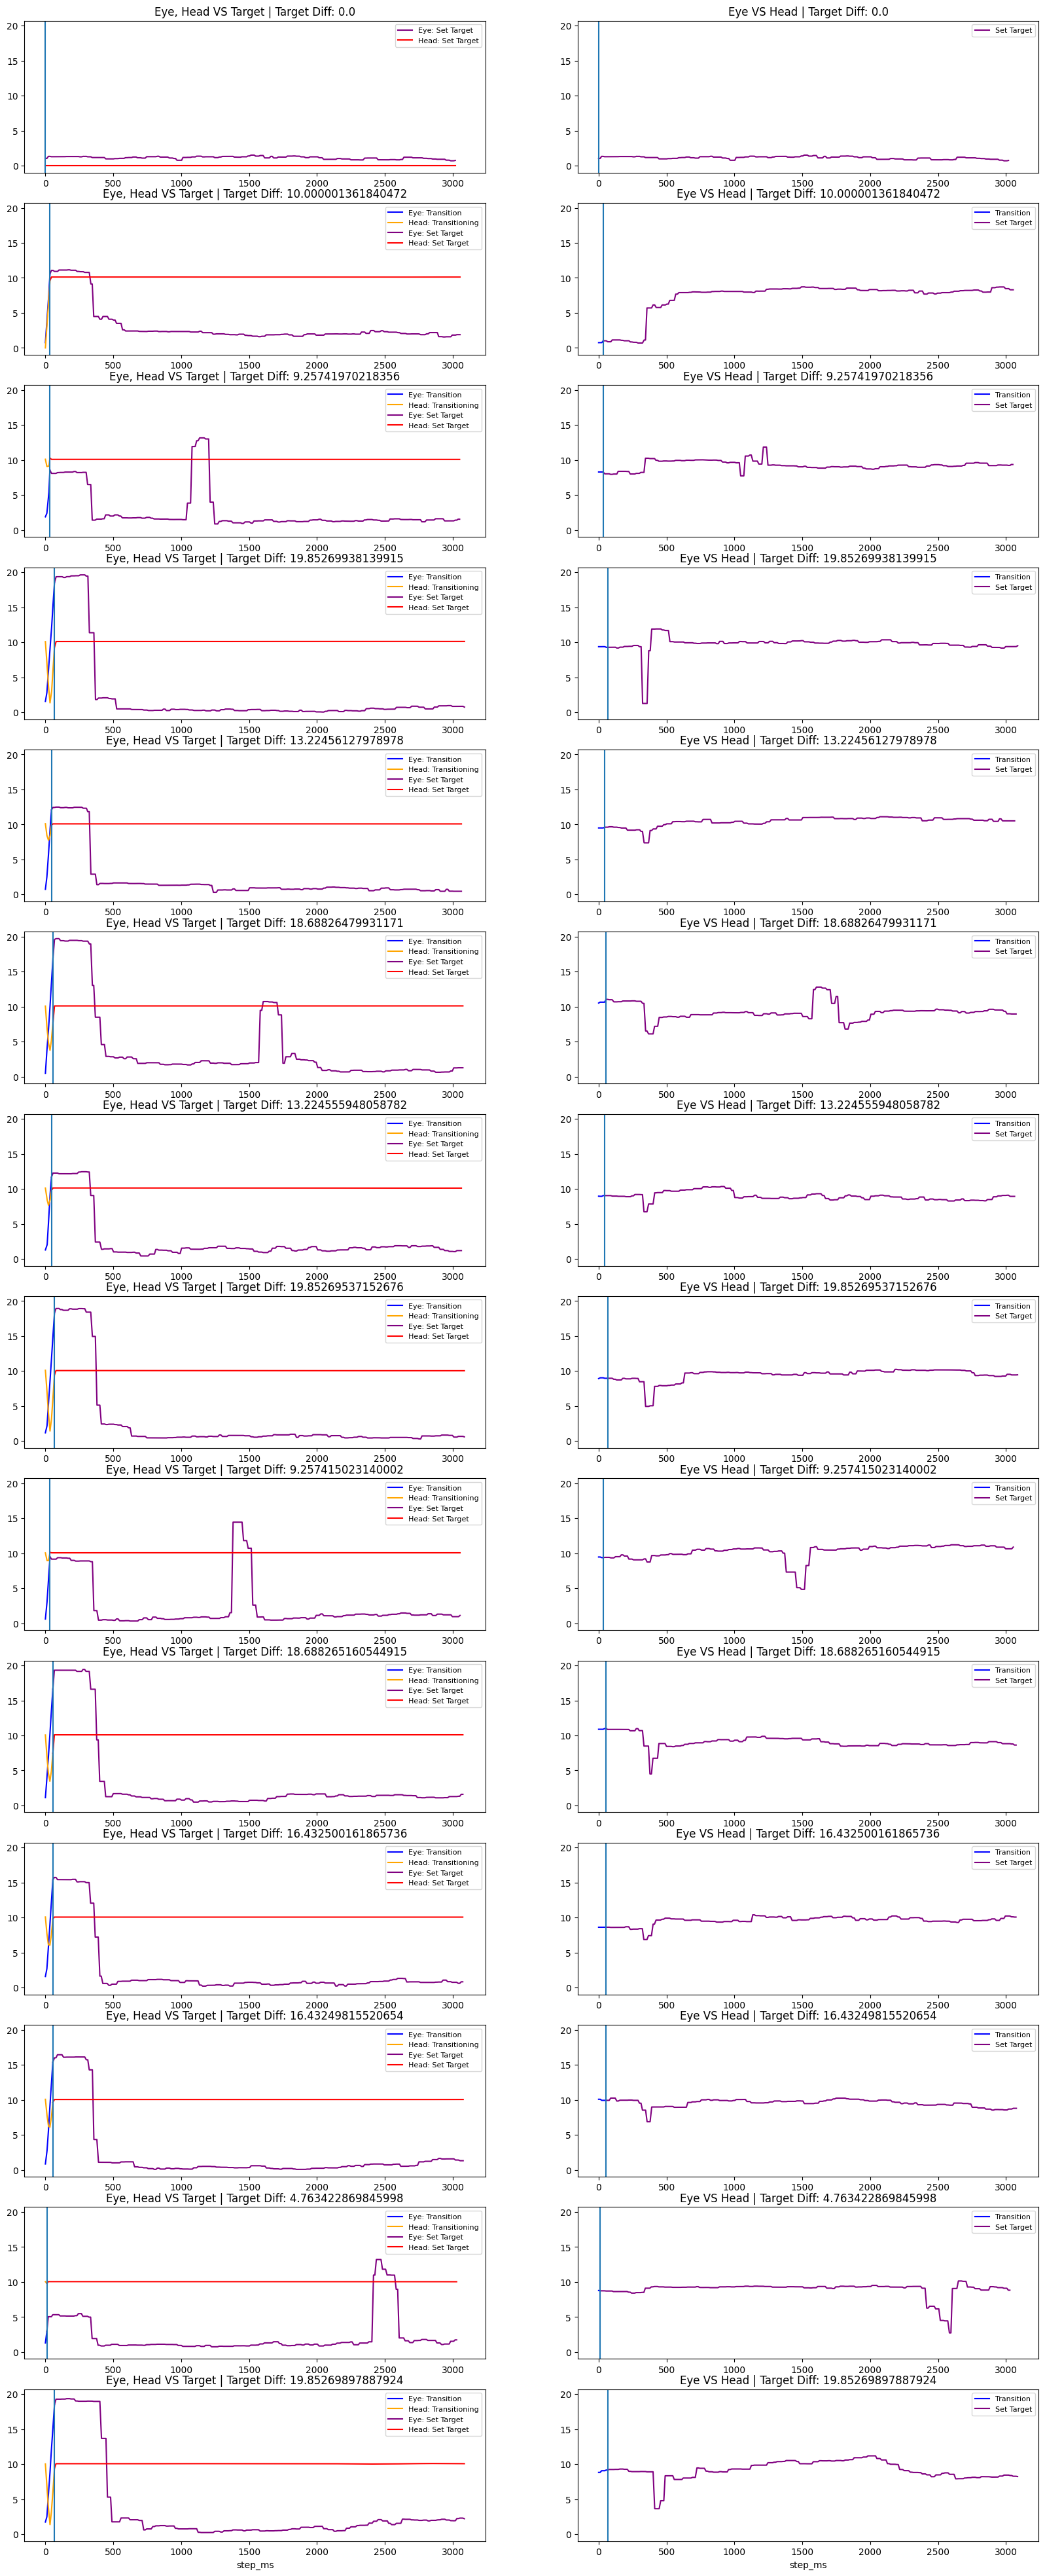

In [94]:
mean_df, sd_df, rmse_df = process_trial('Restricted_10d')
performances.append((mean_df, sd_df, rmse_df))

### 20deg

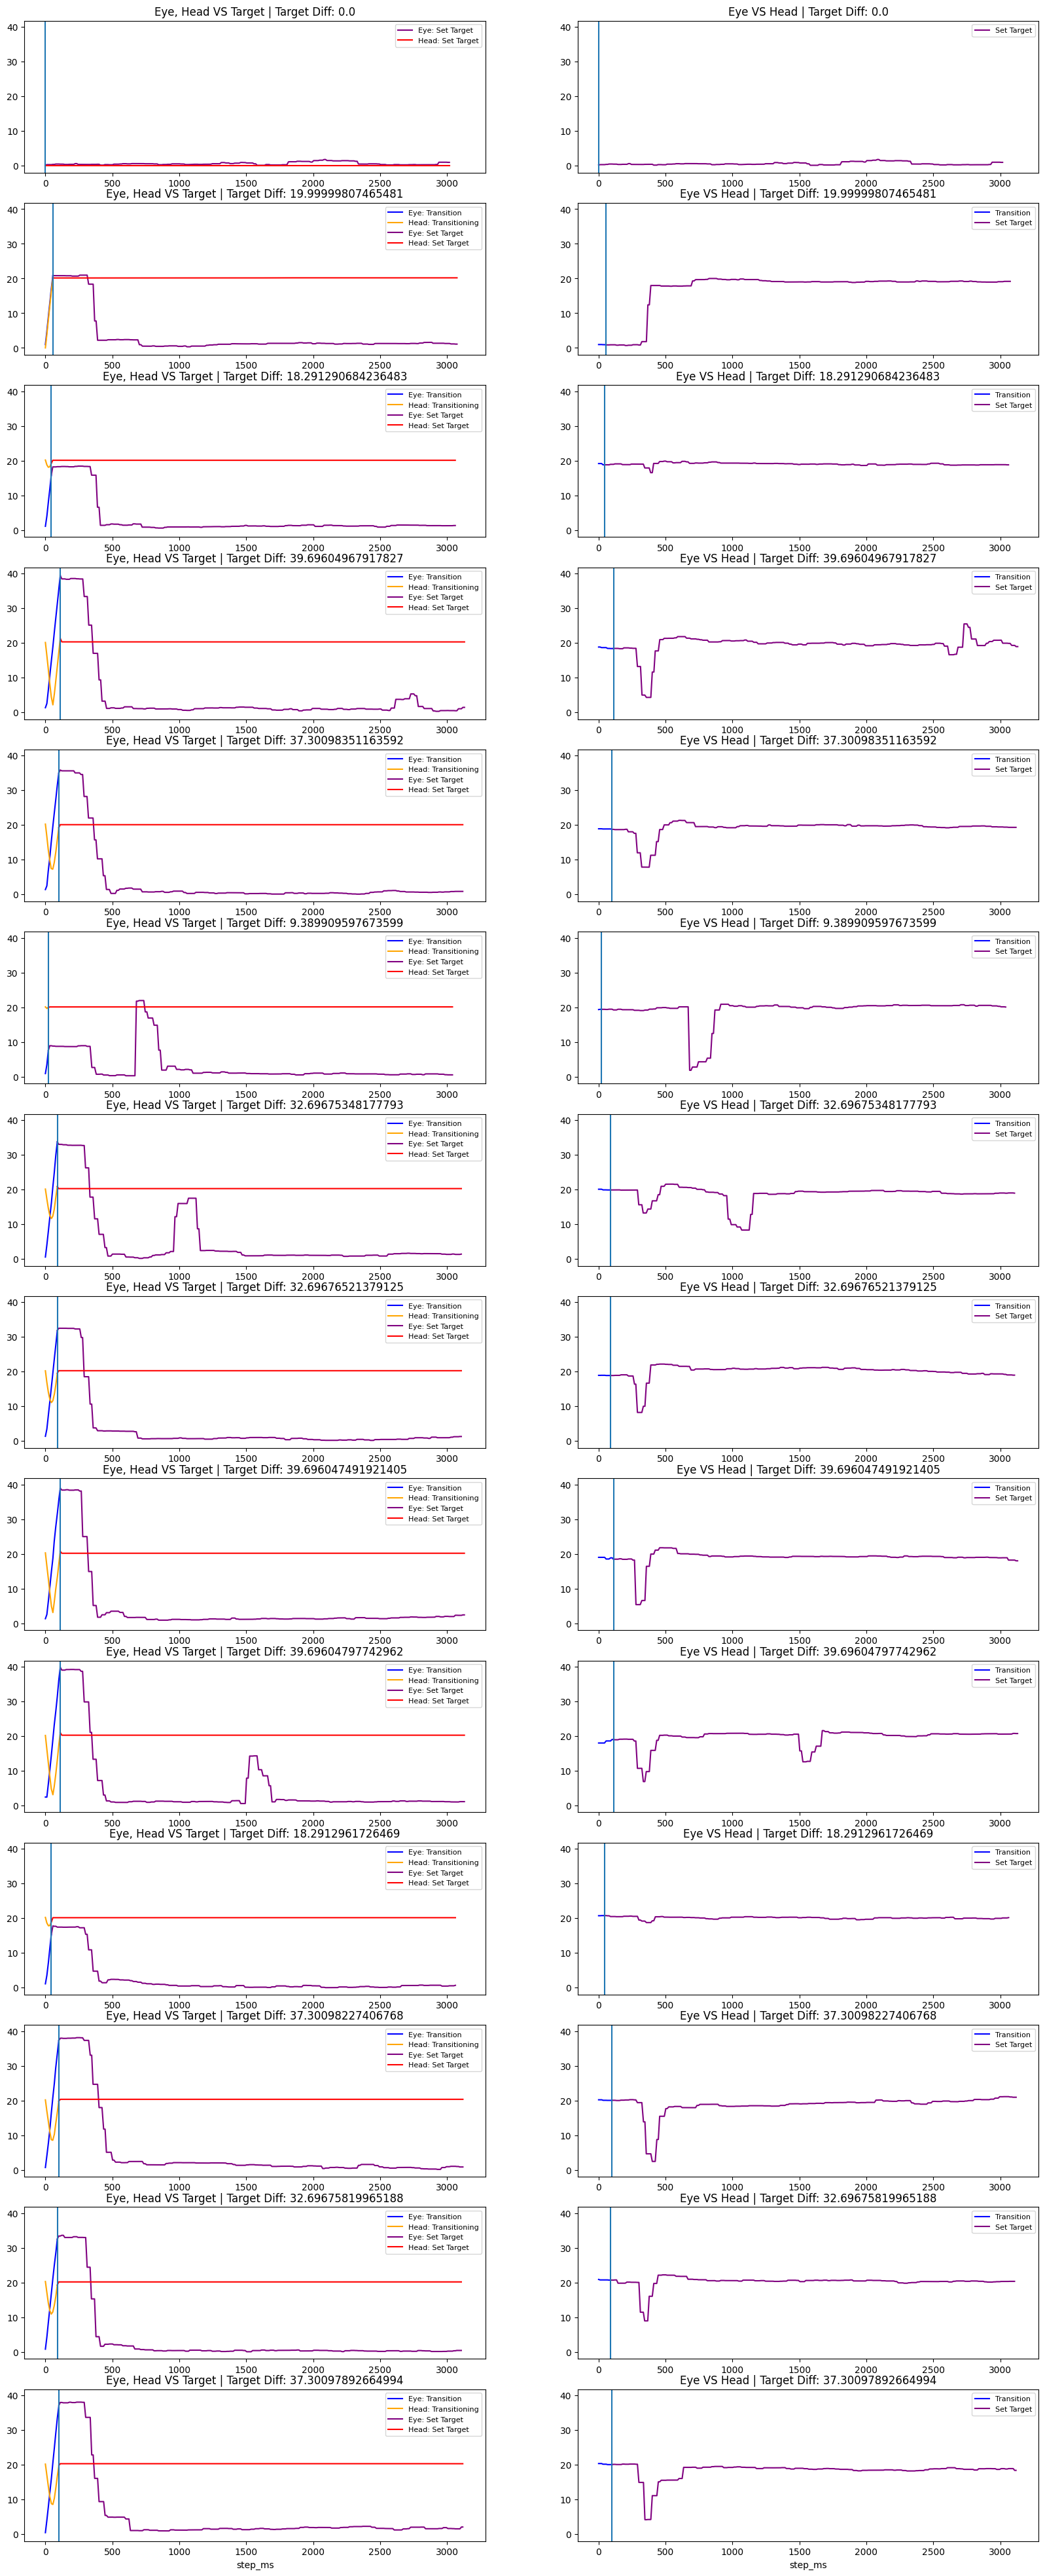

In [95]:
mean_df, sd_df, rmse_df = process_trial('Restricted_20d')
performances.append((mean_df, sd_df, rmse_df))

### 30deg

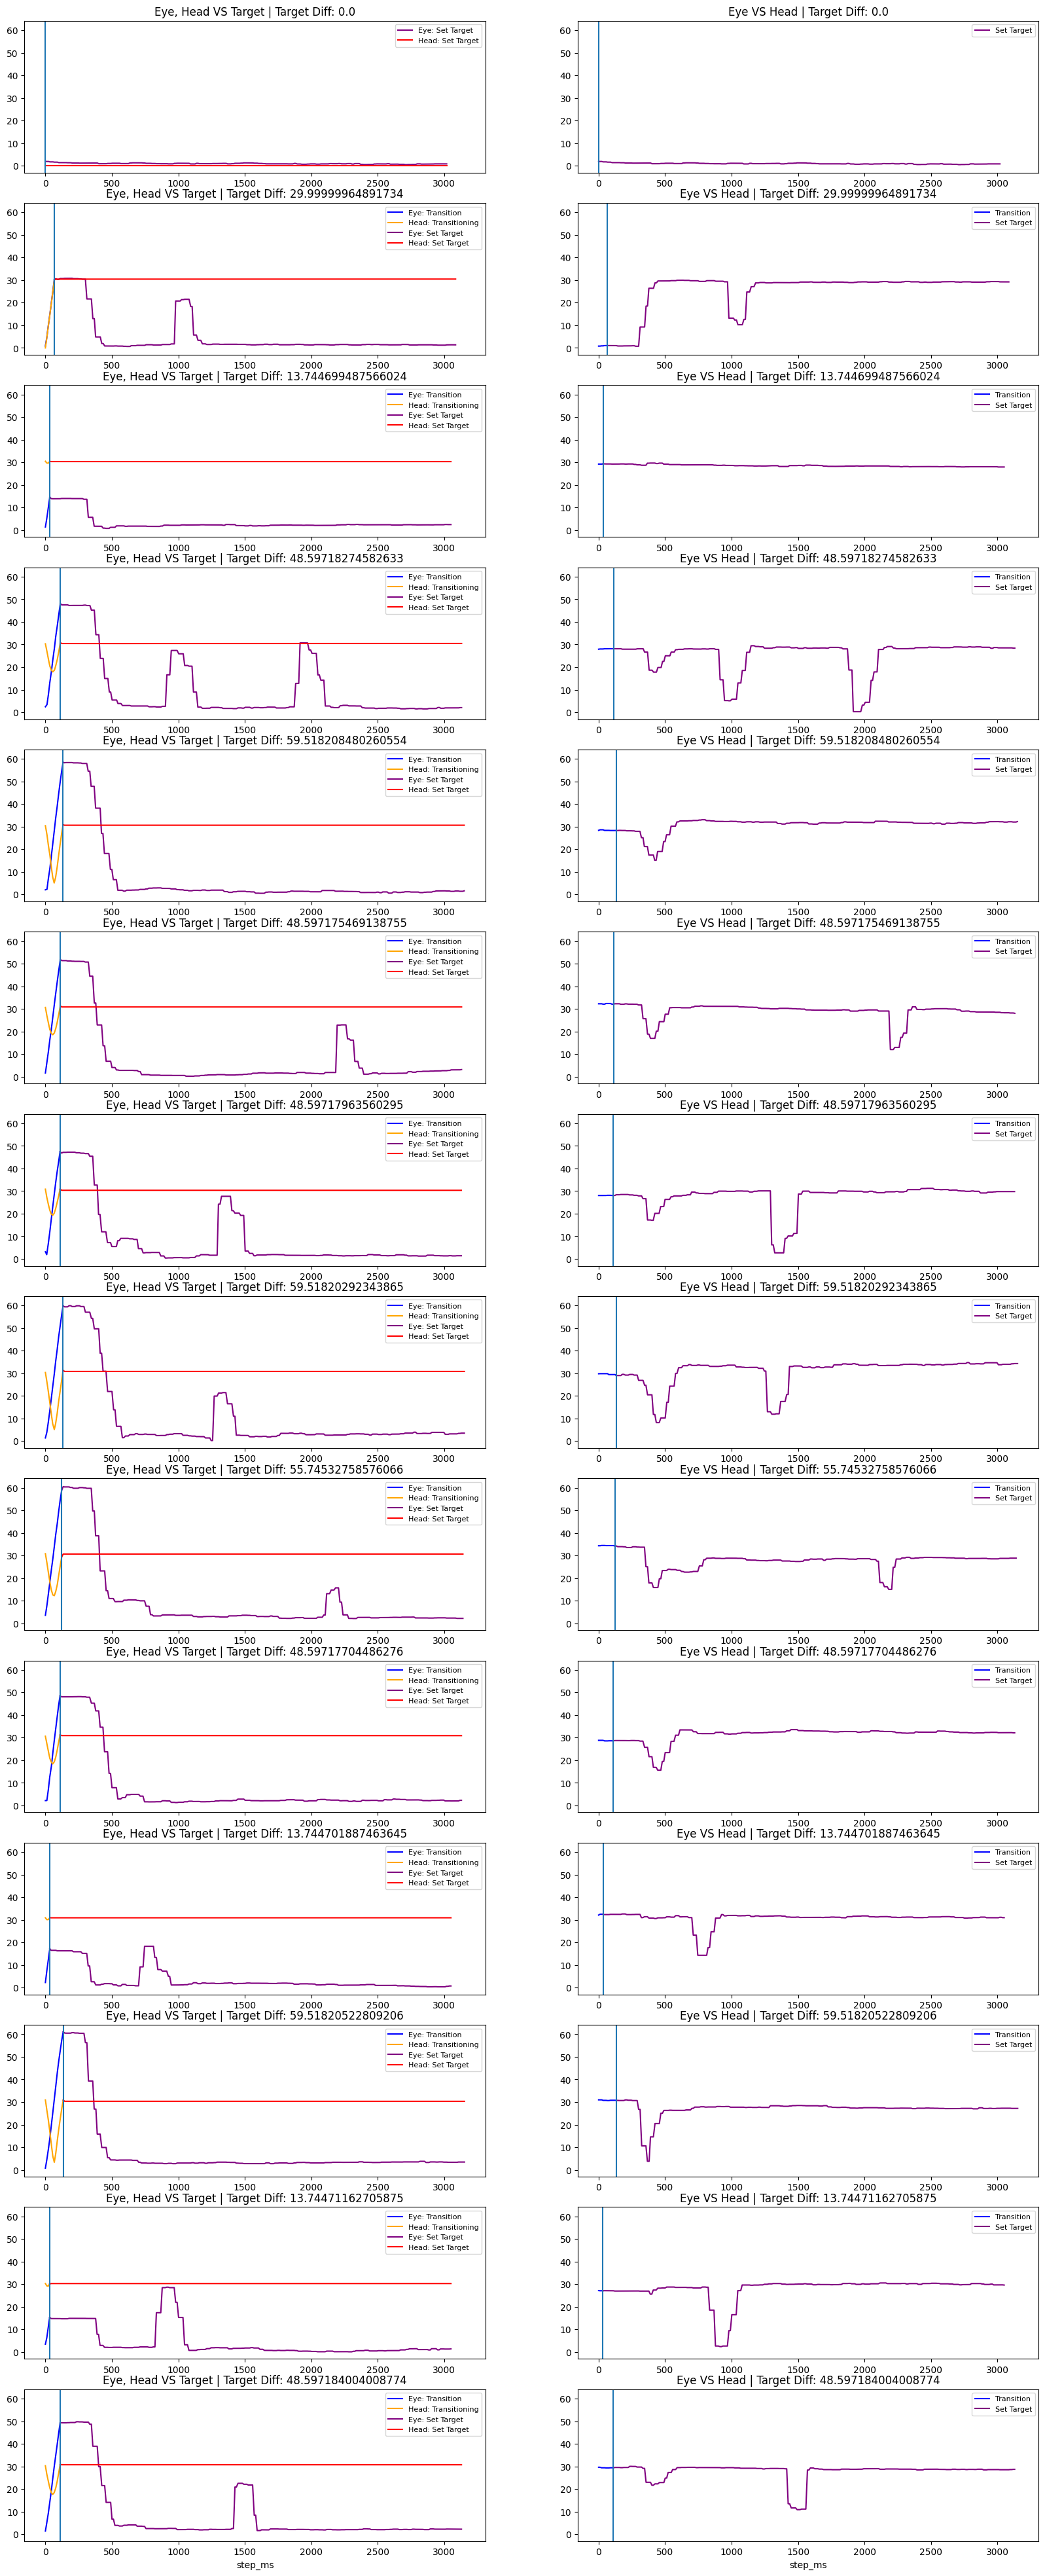

In [96]:
mean_df, sd_df, rmse_df = process_trial('Restricted_30d')
performances.append((mean_df, sd_df, rmse_df))

### 40deg

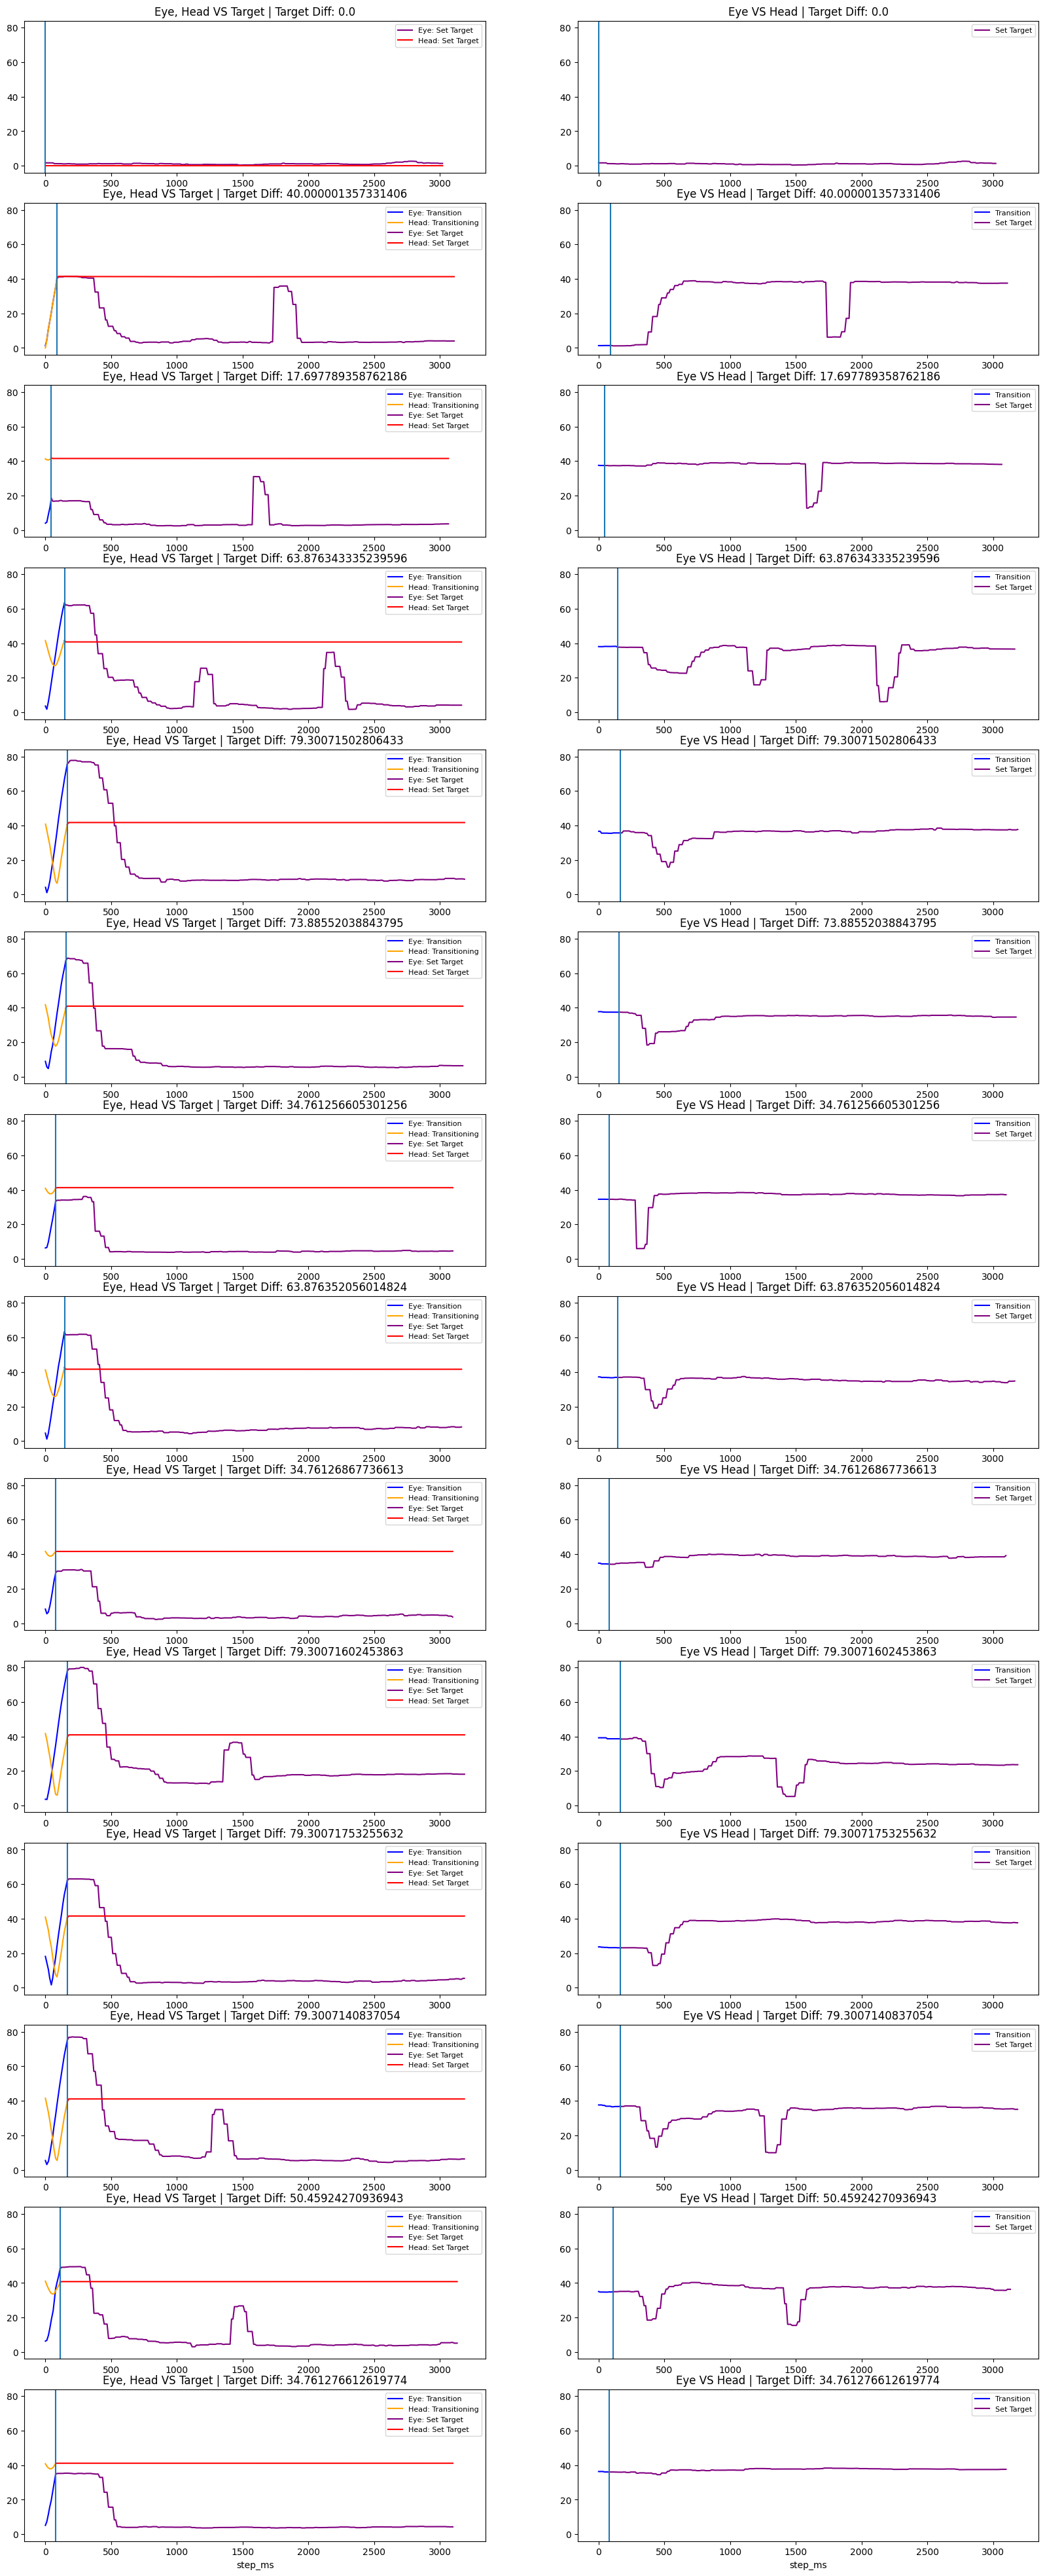

In [97]:
mean_df, sd_df, rmse_df = process_trial('Restricted_40d')
performances.append((mean_df, sd_df, rmse_df))

## Free

### 10deg

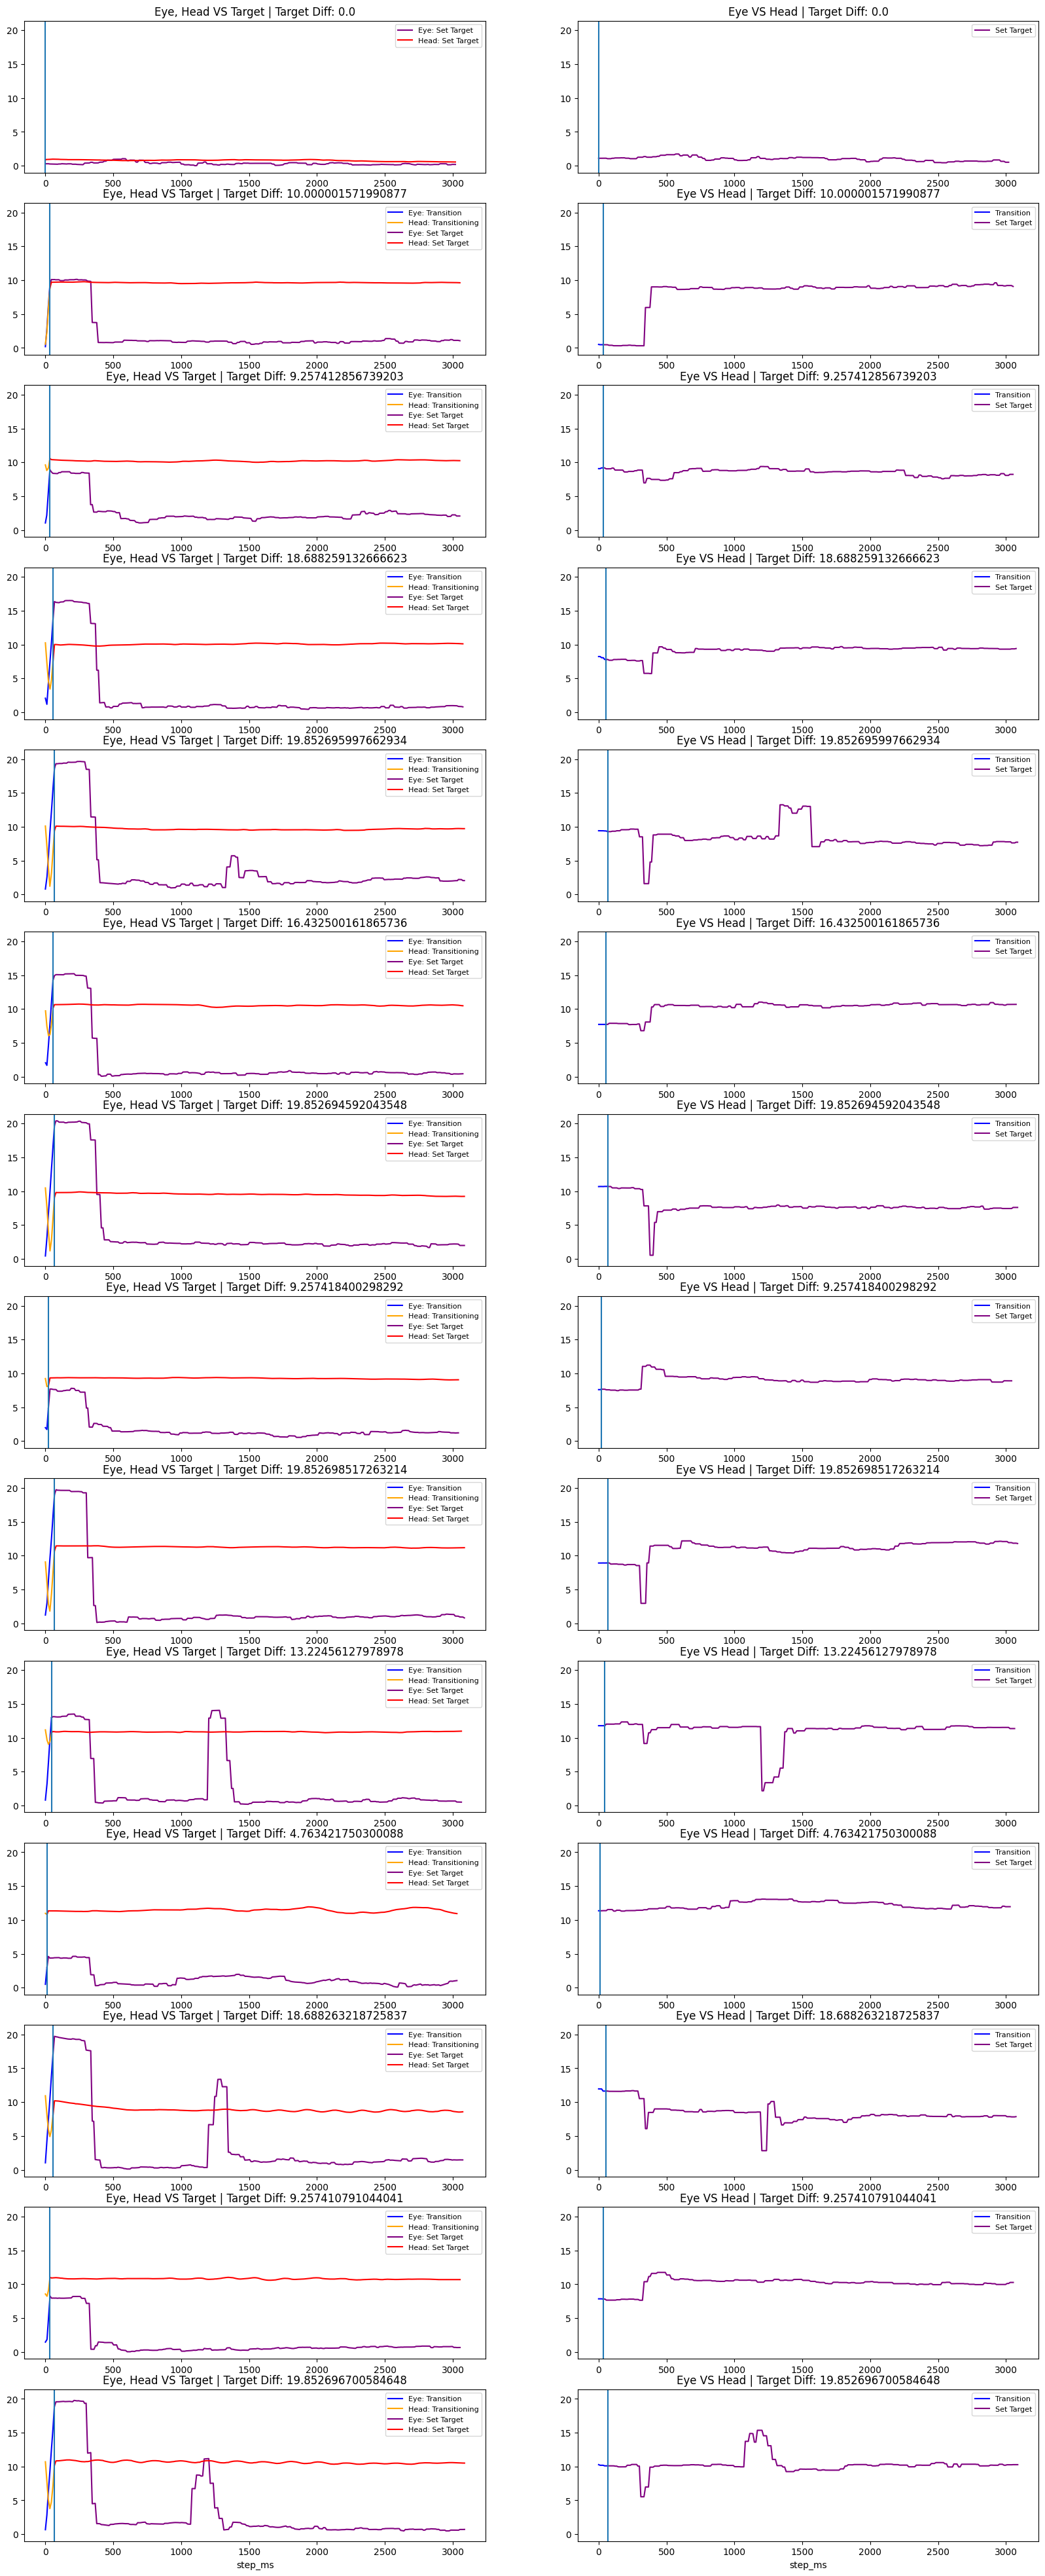

In [98]:
mean_df, sd_df, rmse_df = process_trial('Free_10d')
performances.append((mean_df, sd_df, rmse_df))

### 20deg

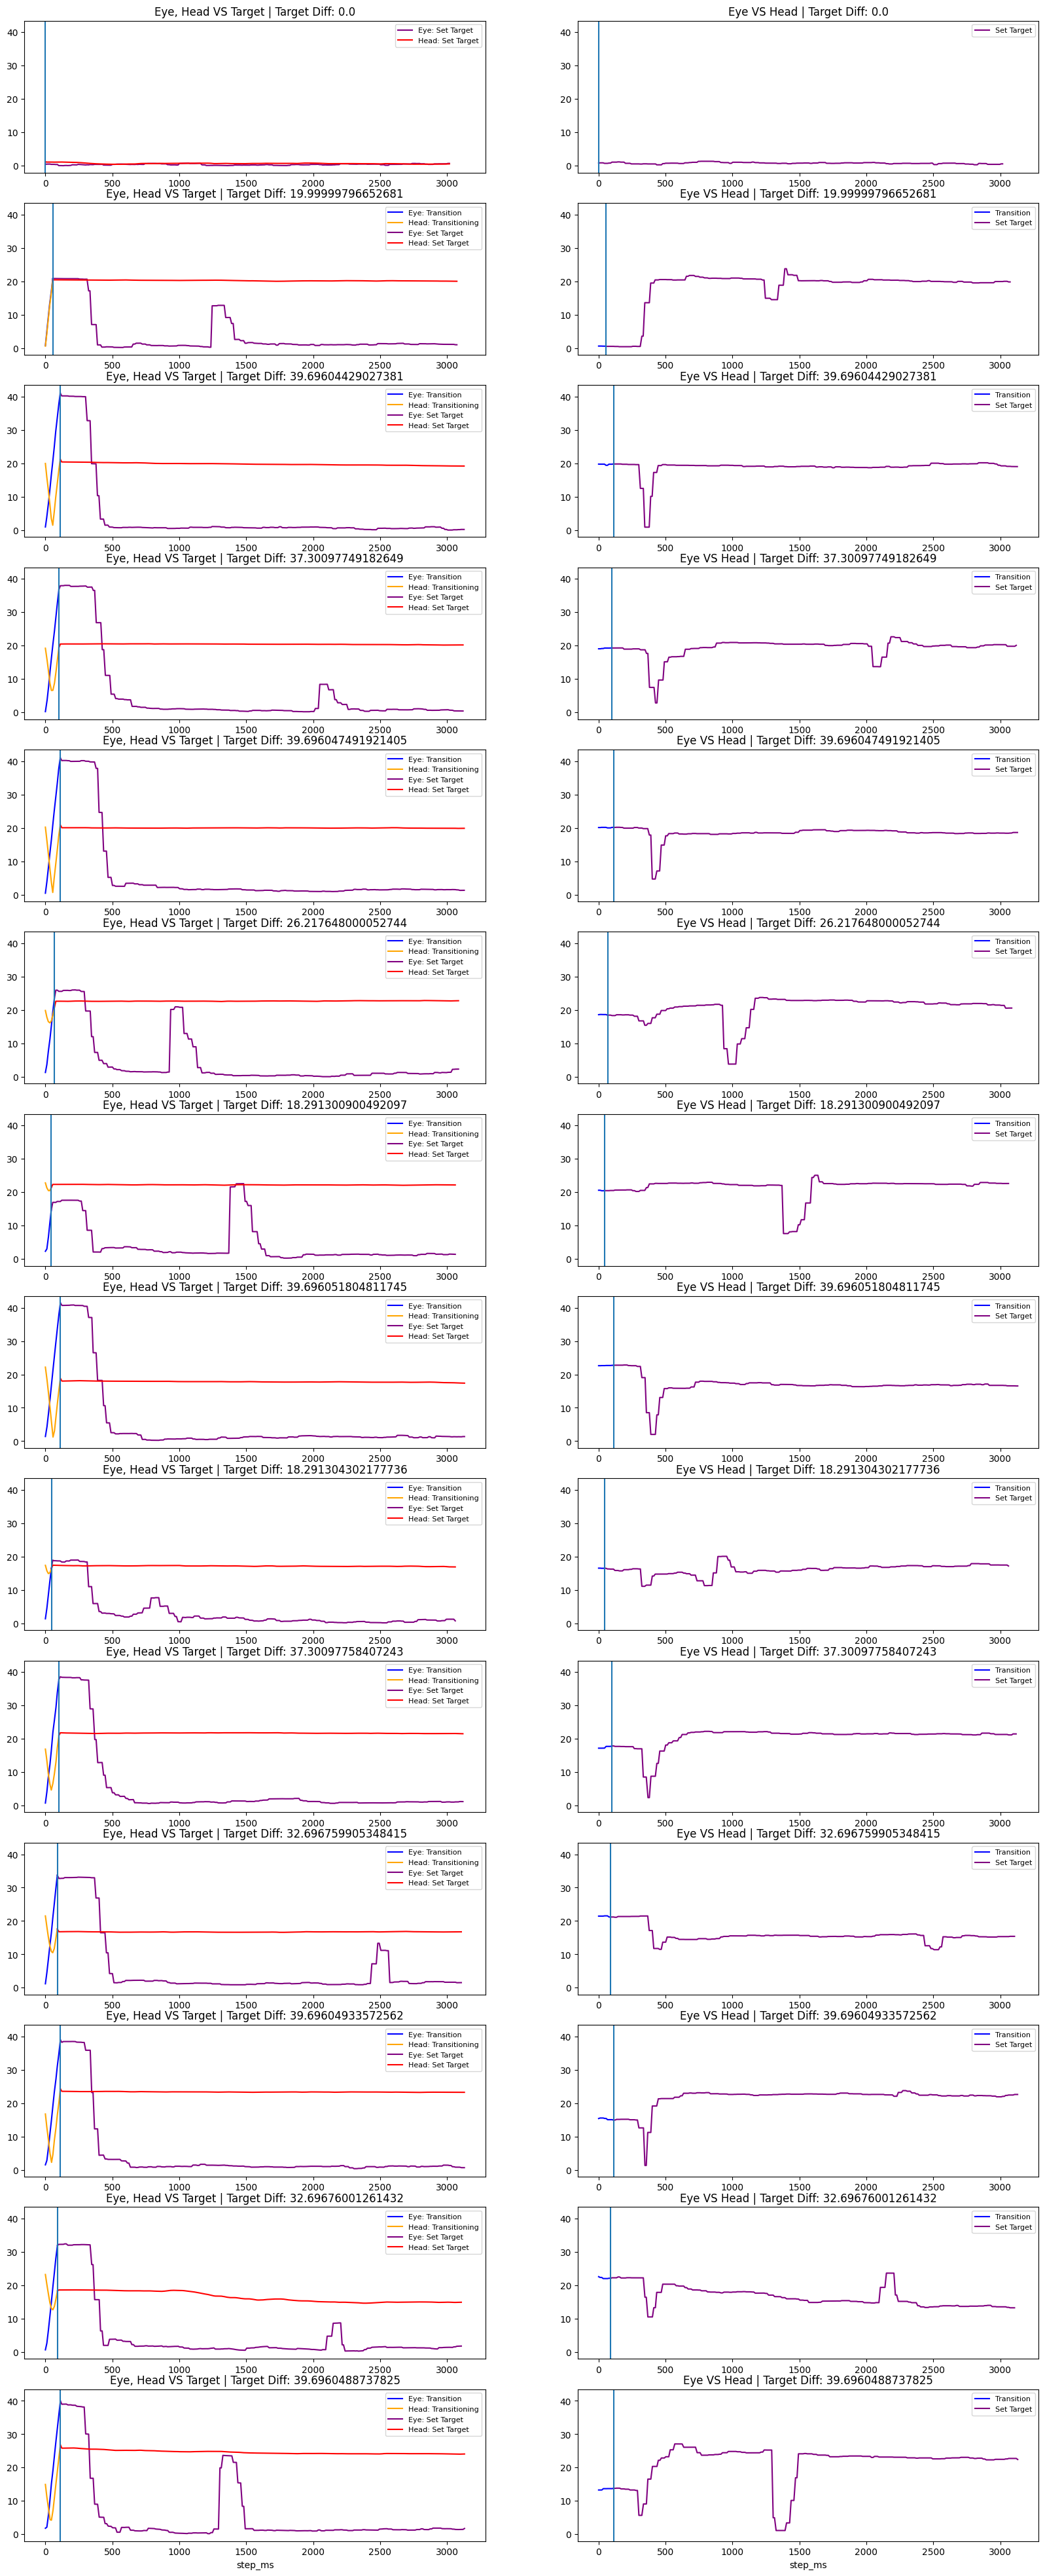

In [99]:
mean_df, sd_df, rmse_df = process_trial('Free_20d')
performances.append((mean_df, sd_df, rmse_df))

### 30deg

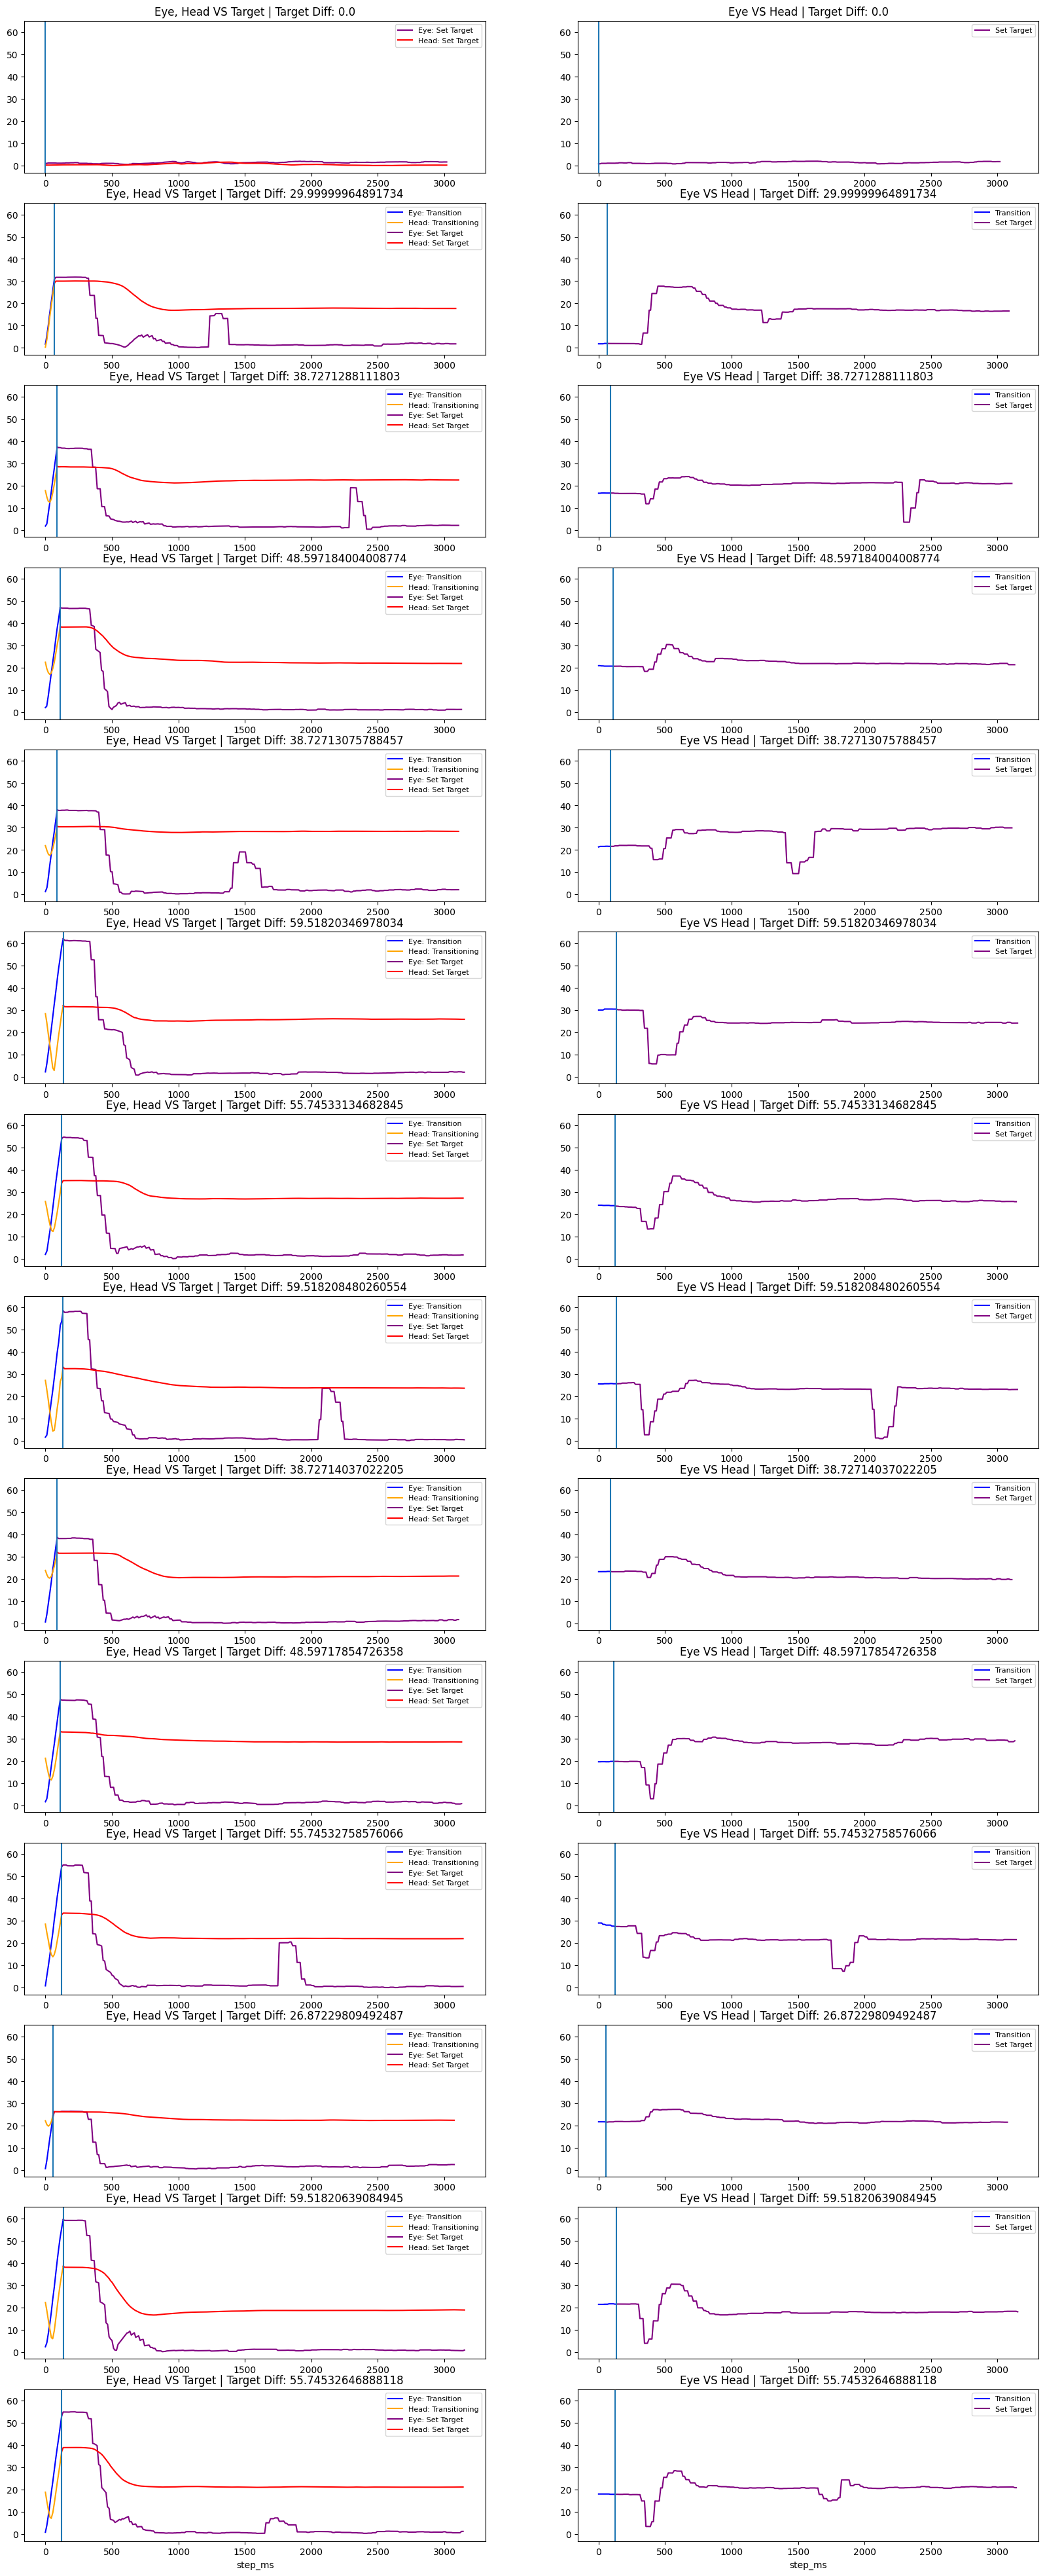

In [100]:
mean_df, sd_df, rmse_df = process_trial('Free_30d')
performances.append((mean_df, sd_df, rmse_df))

### 40deg

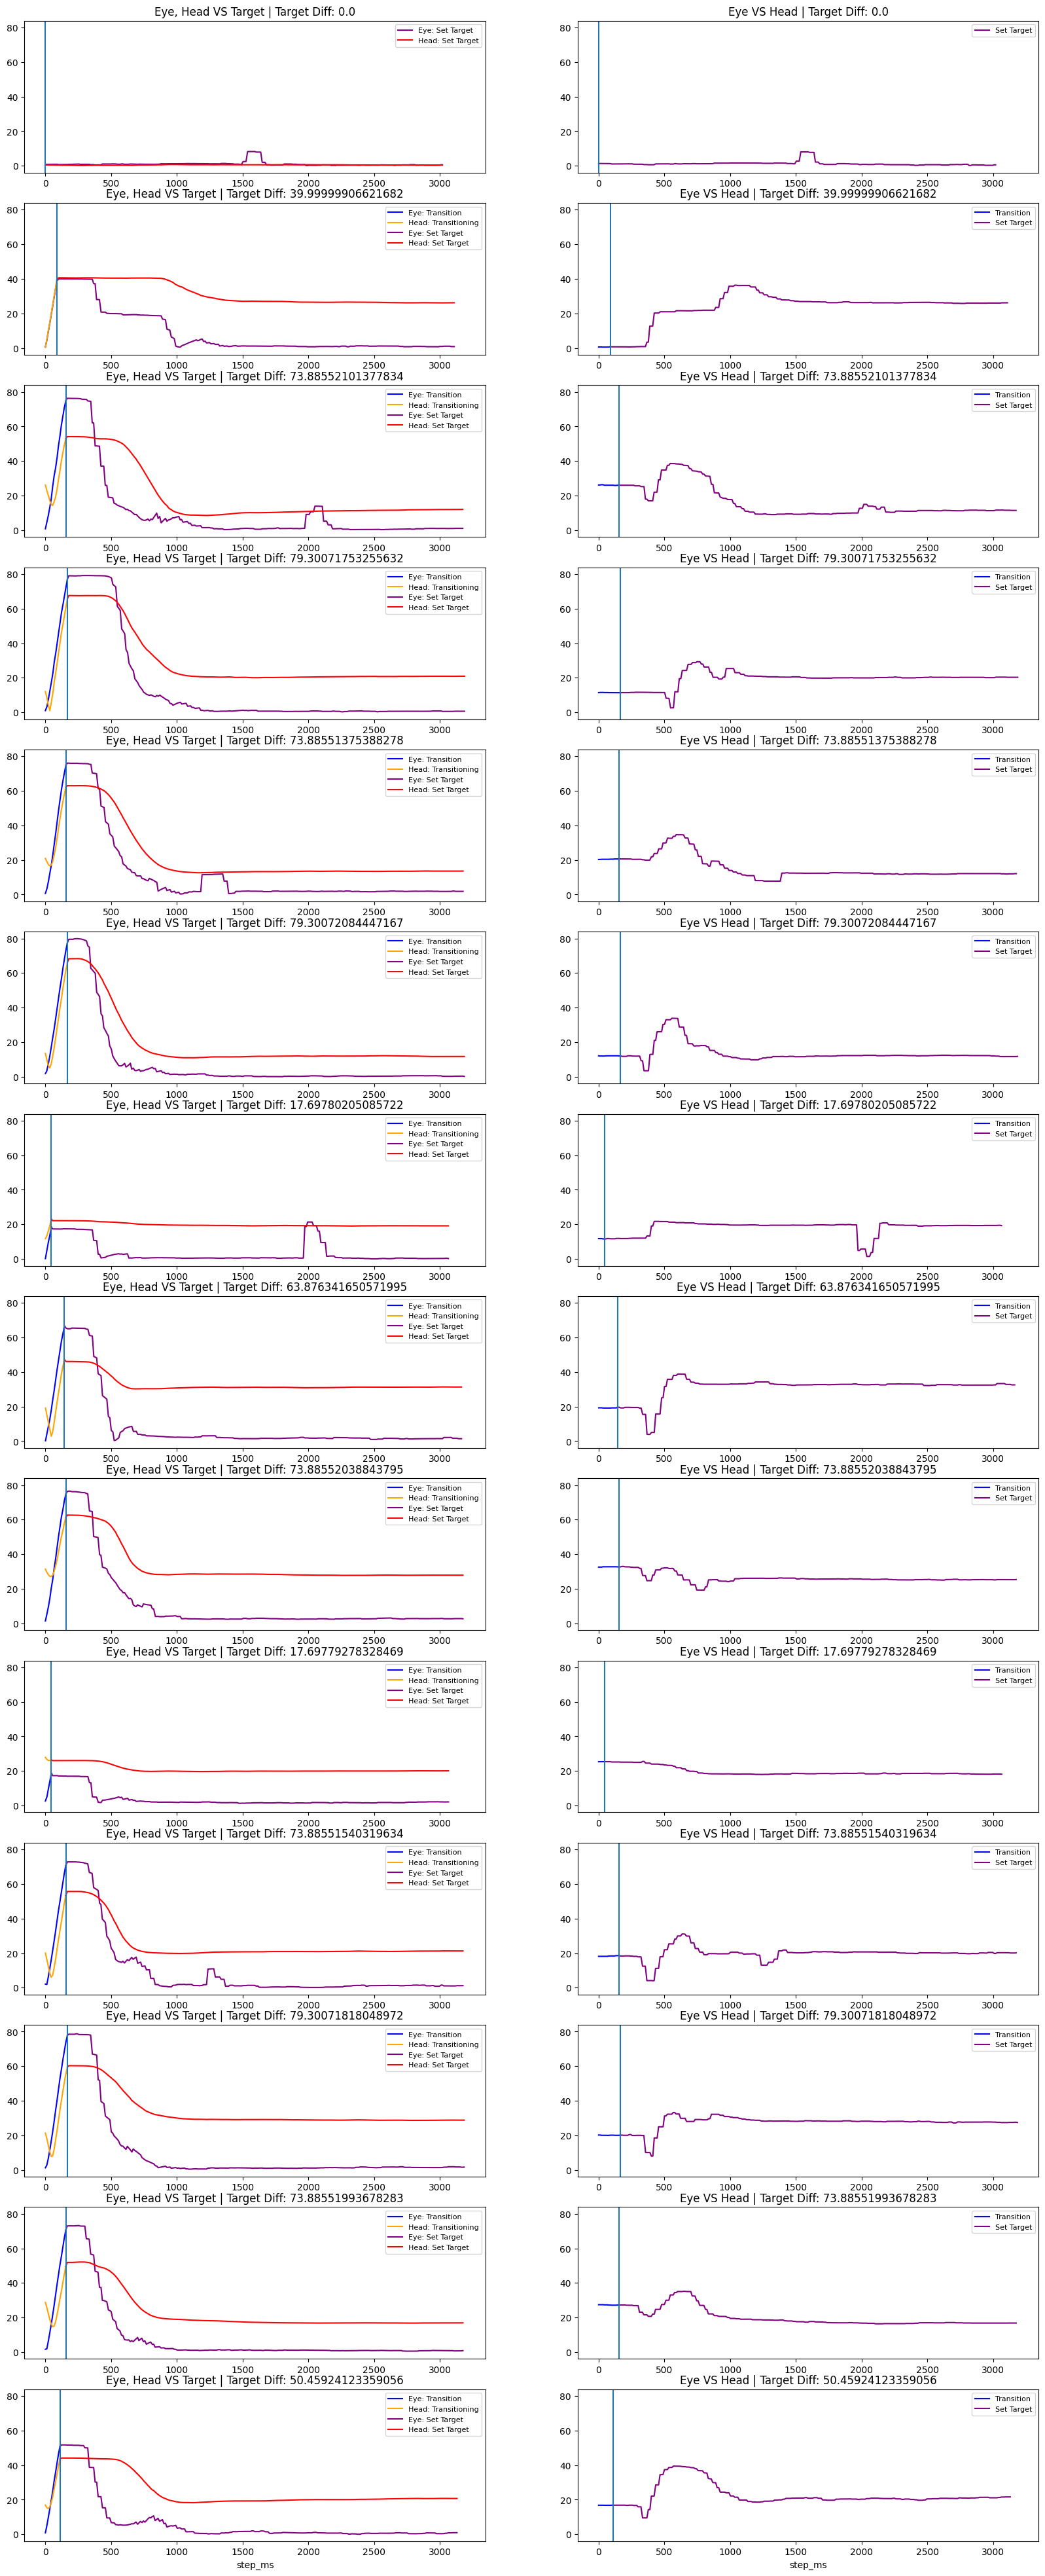

In [101]:
mean_df, sd_df, rmse_df = process_trial('Free_40d')
performances.append((mean_df, sd_df, rmse_df))

# Performances

In [116]:
# Step 1: Unzip tuples into 3 lists of DataFrames
dfs_grouped = list(zip(*performances))  # results in 3 tuples of DataFrames

# Step 2: Merge each group with keys to prevent index collisions
merged = [
    pd.concat(group, keys=[f'sample_{i}' for i in range(len(group))])
    for group in dfs_grouped
]

# merged[0] -> all first DataFrames
# merged[1] -> all second DataFrames
# merged[2] -> all third DataFrames

# Optional: name the new outer index level
for df in merged:
    df.index.names = ['sample', 'original_index']
    df.index = [f"{i}_{j}" for i, j in df.index]
    df = df.reset_index(drop=True, inplace=True)

merged[0]

avg_target_diff  head_target_diff  avg_head_diff  target_diff  \
0           1.949936         10.112012       8.362588    10.000001   
1           2.925354         10.097954       9.177867     9.257420   
2           0.262785         10.112811      10.035641    19.852699   
3           0.909002         10.091204      10.679966    13.224561   
4           3.443958         10.106105       9.230816    18.688265   
..               ...               ...            ...          ...   
99          1.648557         19.829257      18.358188    17.697793   
100         1.342198         20.616938      20.008050    73.885515   
101         0.962759         29.154687      28.461123    79.300718   
102         1.130580         17.622624      17.954859    73.885520   
103         1.106510         19.207021      20.133449    50.459241   

    head_motion spread  
0    Restricted    10d  
1    Restricted    10d  
2    Restricted    10d  
3    Restricted    10d  
4    Restricted    10d  
..          ...    ...  
99         Free    40d  
100        Free    40d  
101        Free    40d  
102        Free    40d  
103        Free    40d  

[104 rows x 6 columns]

<Axes: xlabel='target_diff', ylabel='avg_head_diff'>

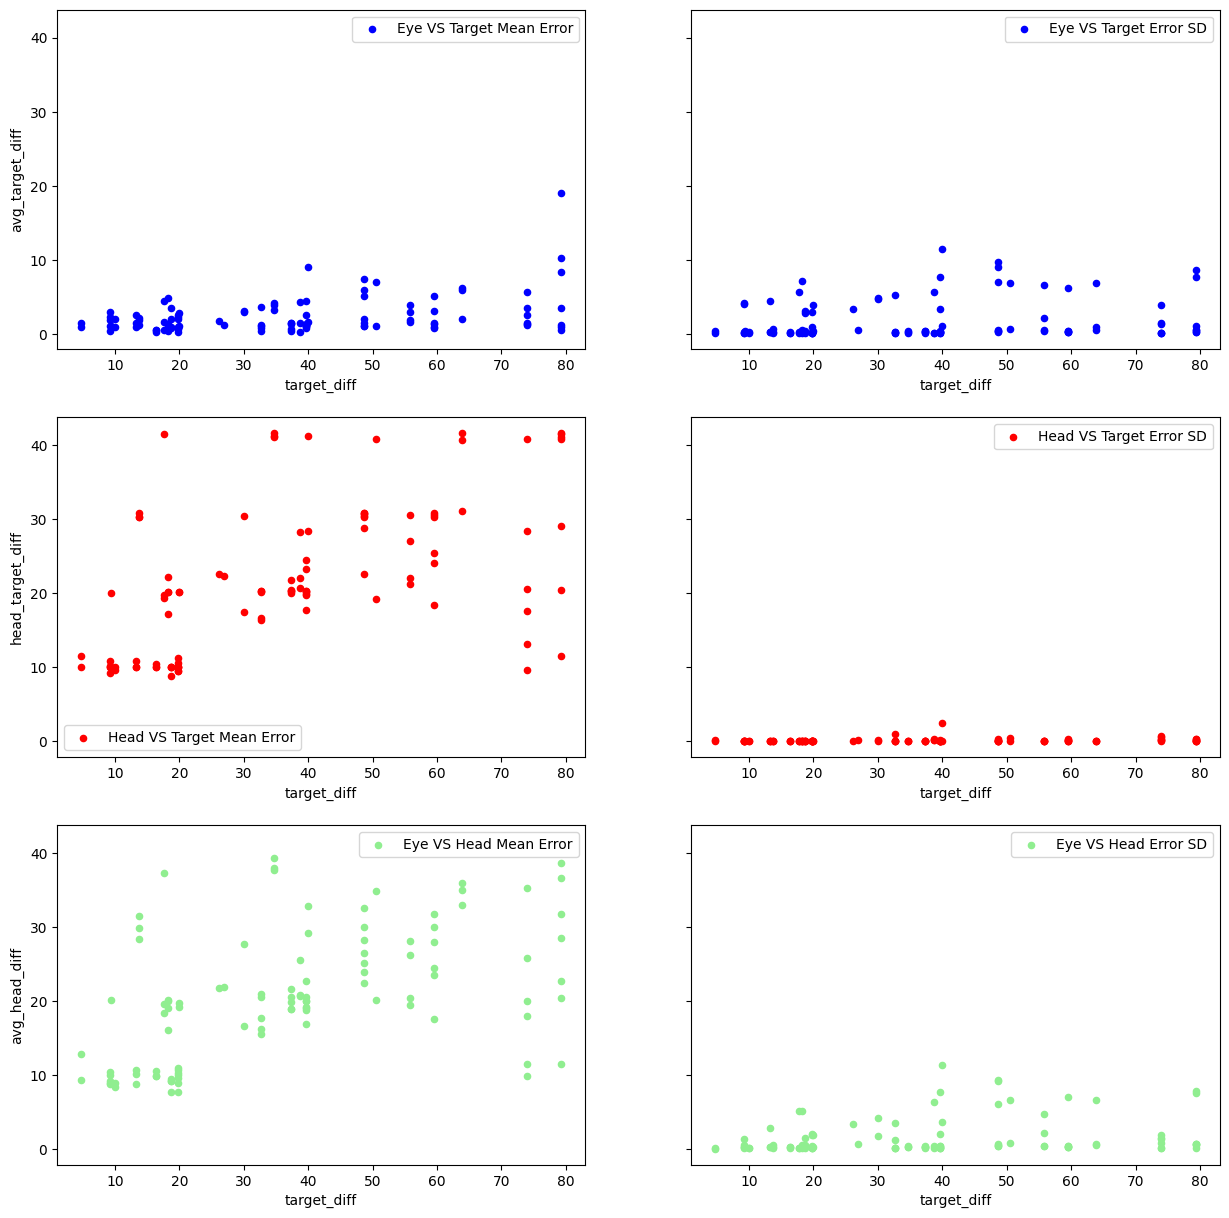

In [128]:
# merged[0] = angular diff mean / accuracy
# merged[1] = angular diff standard deviation / precision
# merged[2] = angular diff rmse / precision

fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)

# Means
merged[0].plot.scatter(x='target_diff', y='avg_target_diff', ax=axes[0][0], c='blue', label='Eye VS Target Mean Error')
merged[0].plot.scatter(x='target_diff', y='head_target_diff', ax=axes[1][0], c='red', label='Head VS Target Mean Error')
merged[0].plot.scatter(x='target_diff', y='avg_head_diff', ax=axes[2][0], c='lightgreen', label='Eye VS Head Mean Error')
# SD
merged[1].plot.scatter(x='target_diff', y='avg_target_diff', ax=axes[0][1], c='blue', label='Eye VS Target Error SD')
merged[1].plot.scatter(x='target_diff', y='head_target_diff', ax=axes[1][1], c='red', label='Head VS Target Error SD')
merged[1].plot.scatter(x='target_diff', y='avg_head_diff', ax=axes[2][1], c='lightgreen', label='Eye VS Head Error SD')